# Preprocessing data for Metastatic Breast Cancer Data (or Ovarian Cancer Data)

The following notebook is meant to be run through papermill parametrized for data type (res_name) of "MBC" (metastatic breast cancer) or "OVC" (ovarian cancer). It can aslo be run directly. Please download the data from the links below prior to running. The notebook QC the data, and saves it to be used later. The data is already filtered according to the original publication. 

[Original paper data can be found here](https://www.nature.com/articles/s41591-020-0844-1#data-availability)

[Data can be downaloded here](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE140819) 

### **We recommend downloading "custom", only the following samples:** 

### MBC:	

#### Nuclei	HTAPP-963-SMP-4741:

GSM4186979_HTAPP-963-SMP-4741_CST_channel2_raw_gene_bc_matrices_h5.h5.gz	

GSM4186979_metadata_HTAPP-963-SMP-4741_CST_channel2.csv.gz

#### Cells HTAPP-963-SMP-4741 & HTAPP-285-SMP-751:

GSM4186974_HTAPP-963-SMP-4741_fresh_channel1_raw_gene_bc_matrices_h5.h5.gz

GSM4186974_metadata_HTAPP-963-SMP-4741_fresh_channel1.csv.gz 

GSM4186973_HTAPP-285-SMP-751_fresh_channel1_raw_gene_bc_matrices_h5.h5.gz	

GSM4186973_metadata_HTAPP-285-SMP-751_fresh_channel1.csv.gz

In [1]:
# import the dependencies
import sys
import sys
import numpy as np
import os
import pandas as pd
import scipy as sp
from scipy.sparse import coo_matrix
import collections
import scanpy as sc
import anndata as ad
import gzip
import re
import shutil
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pickle
from pathlib import Path

# Ensure PYTHONPATH includes the parent directory of 'src'
sys.path.insert(1, "../../")
sys.path.insert(1, "../")
sys.path.insert(1, "../../../../../")

from src.helpers import (
    match_cell_types,
    load_MBC_data,
    make_prop_table,
    assign_cell_types,
    load_OVC_data,
)

We'll demostrate with metastatic breast cancer data from: 

In [2]:
res_name = "MBC"

In [3]:
# Parameters
res_name = "MBC"


## Reading in the single-cell and single-nucleus data

Single-Cell

In [4]:
if res_name == "MBC":
    sc_adata, sc_metadata = load_MBC_data("single_cell")
elif res_name == "OVC":
    sc_adata, sc_metadata = load_OVC_data("single_cell")
sc_metadata

Extracting /projects/aivich@xsede.org/deconvolution_sc_sn_comparison/notebooks/../data/MBC/GSE140819_RAW.tar to /projects/aivich@xsede.org/deconvolution_sc_sn_comparison/notebooks/../data/MBC/...


Extraction complete.


/projects/aivich@xsede.org/.conda/envs/env_deconv/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


,Unnamed: 0,annotate,nReads,nUMI,nGene,percent_mito,emptydrop,doublet,cell
0,HTAPP-963-SMP-4741_fresh-AAACCTGAGACCTTTG,T cell,2544,1098,603,0.063752,False,False,AAACCTGAGACCTTTG-1
1,HTAPP-963-SMP-4741_fresh-AAACCTGAGTACTTGC,NK cell,3185,1362,706,0.041850,False,False,AAACCTGAGTACTTGC-1
2,HTAPP-963-SMP-4741_fresh-AAACCTGCAAGAGGCT,Epithelial cell,28067,11621,2347,0.003012,False,False,AAACCTGCAAGAGGCT-1
3,HTAPP-963-SMP-4741_fresh-AAACCTGCAGTTAACC,T cell,5698,2386,1004,0.021375,False,False,AAACCTGCAGTTAACC-1
4,HTAPP-963-SMP-4741_fresh-AAACCTGCATCACGTA,Endothelial cell,11602,5093,1985,0.036913,False,False,AAACCTGCATCACGTA-1
...,...,...,...,...,...,...,...,...,...
5158,HTAPP-963-SMP-4741_fresh-TTTGTCACATGCAACT,T cell,5506,2354,1059,0.037383,False,False,TTTGTCACATGCAACT-1
5159,HTAPP-963-SMP-4741_fresh-TTTGTCAGTACTTGAC,Fibroblast,4279,1811,943,0.023744,False,False,TTTGTCAGTACTTGAC-1
5160,HTAPP-963-SMP-4741_fresh-TTTGTCATCAGGCAAG,T cell,2364,1021,535,0.043095,False,False,TTTGTCATCAGGCAAG-1
5161,HTAPP-963-SMP-4741_fresh-TTTGTCATCGGTGTTA,B cell,3513,1555,591,0.054019,False,False,TTTGTCATCGGTGTTA-1


Single-Nucleus:

In [5]:
if res_name == "MBC":
    sn_adata, sn_metadata = load_MBC_data("single_nucleus")
elif res_name == "OVC":
    sn_adata, sn_metadata = load_OVC_data("single_nucleus")
sn_metadata

Skipping extraction: Data already exists in /projects/aivich@xsede.org/deconvolution_sc_sn_comparison/notebooks/../data/MBC/.


/projects/aivich@xsede.org/.conda/envs/env_deconv/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


,Unnamed: 0,annotate,nReads,nUMI,nGene,percent_mito,emptydrop,doublet,cell
0,HTAPP-963-SMP-4741_fresh-AAACCTGAGACCTTTG,T cell,2544,1098,603,0.063752,False,False,AAACCTGAGACCTTTG-1
1,HTAPP-963-SMP-4741_fresh-AAACCTGAGTACTTGC,NK cell,3185,1362,706,0.041850,False,False,AAACCTGAGTACTTGC-1
2,HTAPP-963-SMP-4741_fresh-AAACCTGCAAGAGGCT,Epithelial cell,28067,11621,2347,0.003012,False,False,AAACCTGCAAGAGGCT-1
3,HTAPP-963-SMP-4741_fresh-AAACCTGCAGTTAACC,T cell,5698,2386,1004,0.021375,False,False,AAACCTGCAGTTAACC-1
4,HTAPP-963-SMP-4741_fresh-AAACCTGCATCACGTA,Endothelial cell,11602,5093,1985,0.036913,False,False,AAACCTGCATCACGTA-1
...,...,...,...,...,...,...,...,...,...
5158,HTAPP-963-SMP-4741_fresh-TTTGTCACATGCAACT,T cell,5506,2354,1059,0.037383,False,False,TTTGTCACATGCAACT-1
5159,HTAPP-963-SMP-4741_fresh-TTTGTCAGTACTTGAC,Fibroblast,4279,1811,943,0.023744,False,False,TTTGTCAGTACTTGAC-1
5160,HTAPP-963-SMP-4741_fresh-TTTGTCATCAGGCAAG,T cell,2364,1021,535,0.043095,False,False,TTTGTCATCAGGCAAG-1
5161,HTAPP-963-SMP-4741_fresh-TTTGTCATCGGTGTTA,B cell,3513,1555,591,0.054019,False,False,TTTGTCATCGGTGTTA-1


And testing Single-cell:

In [6]:
if res_name == "MBC":
    sc_adata_test, sc_metadata_test = load_MBC_data("single_cell", load_testing=True)
elif res_name == "OVC":
    sc_adata_test, sc_metadata_test = load_OVC_data("single_cell", load_testing=True)
sc_metadata_test

Skipping extraction: Data already exists in /projects/aivich@xsede.org/deconvolution_sc_sn_comparison/notebooks/../data/MBC/.


/projects/aivich@xsede.org/.conda/envs/env_deconv/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


,Unnamed: 0,annotate,nReads,nUMI,nGene,percent_mito,emptydrop,doublet,cell
0,HTAPP-285-SMP-751_fresh_channel1-AAACCTGAGAGTGACC,Epithelial cell,28587,14260,3215,0.021388,False,False,AAACCTGAGAGTGACC-1
1,HTAPP-285-SMP-751_fresh_channel1-AAACCTGAGCAAATCA,Epithelial cell,70728,36824,5838,0.070633,False,False,AAACCTGAGCAAATCA-1
2,HTAPP-285-SMP-751_fresh_channel1-AAACCTGGTACGCACC,Epithelial cell,44899,23309,4620,0.065425,False,False,AAACCTGGTACGCACC-1
3,HTAPP-285-SMP-751_fresh_channel1-AAACCTGGTCGAGATG,Epithelial cell,28103,14936,3753,0.105182,False,False,AAACCTGGTCGAGATG-1
4,HTAPP-285-SMP-751_fresh_channel1-AAACCTGTCCCAAGAT,T cell,7402,3768,1341,0.021497,False,False,AAACCTGTCCCAAGAT-1
...,...,...,...,...,...,...,...,...,...
4458,HTAPP-285-SMP-751_fresh_channel1-TTTGTCAGTACCGAGA,Epithelial cell,21192,11213,3164,0.050299,False,False,TTTGTCAGTACCGAGA-1
4459,HTAPP-285-SMP-751_fresh_channel1-TTTGTCAGTCAGCTAT,Epithelial cell,53299,27905,4721,0.054793,False,False,TTTGTCAGTCAGCTAT-1
4460,HTAPP-285-SMP-751_fresh_channel1-TTTGTCAGTCTAGCGC,Endothelial cell,2947,1509,697,0.001325,False,False,TTTGTCAGTCTAGCGC-1
4461,HTAPP-285-SMP-751_fresh_channel1-TTTGTCATCAGTTTGG,Macrophage,16329,8690,2144,0.024856,False,False,TTTGTCATCAGTTTGG-1


In [7]:
# QC, making sure our cells are the same in metadata and count matrix
idx_keep = np.intersect1d(sn_metadata.cell.values, sn_adata.obs.index.values)
sn_adata = sn_adata[idx_keep, :]

idx_keep = np.intersect1d(sc_metadata.cell.values, sc_adata.obs.index.values)
sc_adata = sc_adata[idx_keep, :]

idx_keep = np.intersect1d(sc_metadata_test.cell.values, sc_adata_test.obs.index.values)
sc_adata_test = sc_adata_test[idx_keep, :]

Assigning information from data:
https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE140819

In [8]:
# data type
sn_adata.obs["data_type"] = "single_nucleus"
sc_adata.obs["data_type"] = "single_cell"
sc_adata_test.obs["data_type"] = "single_cell"

/projects/aivich@xsede.org/code-server/tmp/ipykernel_3535916/43901299.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  sn_adata.obs["data_type"] = "single_nucleus"
/projects/aivich@xsede.org/code-server/tmp/ipykernel_3535916/43901299.py:3: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  sc_adata.obs["data_type"] = "single_cell"
/projects/aivich@xsede.org/code-server/tmp/ipykernel_3535916/43901299.py:4: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  sc_adata_test.obs["data_type"] = "single_cell"


## QC

QC of count matrix, rouhghly based on:

Scanpy https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html

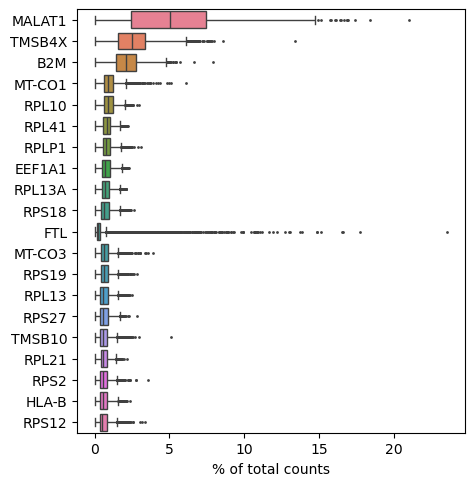

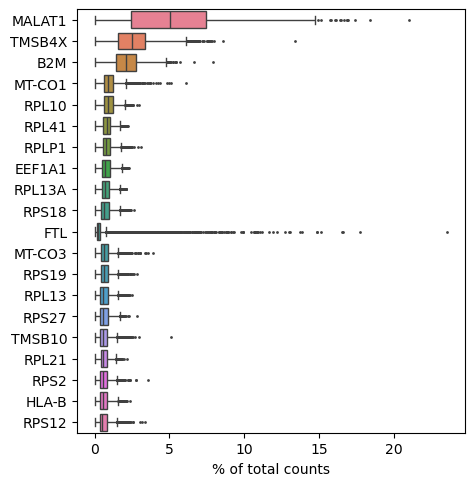

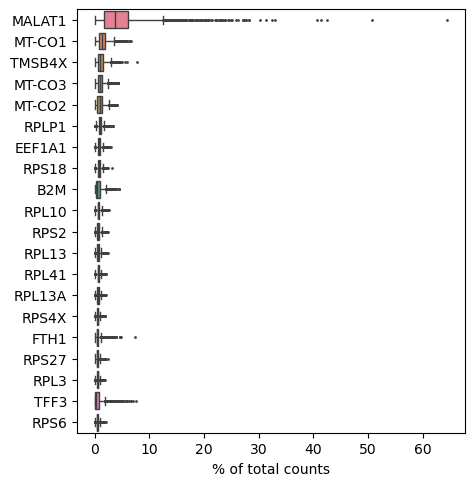

In [9]:
sc.pl.highest_expr_genes(
    sn_adata,
    n_top=20,
)
sc.pl.highest_expr_genes(
    sc_adata,
    n_top=20,
)
sc.pl.highest_expr_genes(
    sc_adata_test,
    n_top=20,
)

In [10]:
# QC, check it is not normalized
print(sn_adata.X.max())
print(sc_adata.X.max())
print(sc_adata_test.X.max())

8788.0
8788.0
8351.0


We'll remove genes with high mitochondrial content

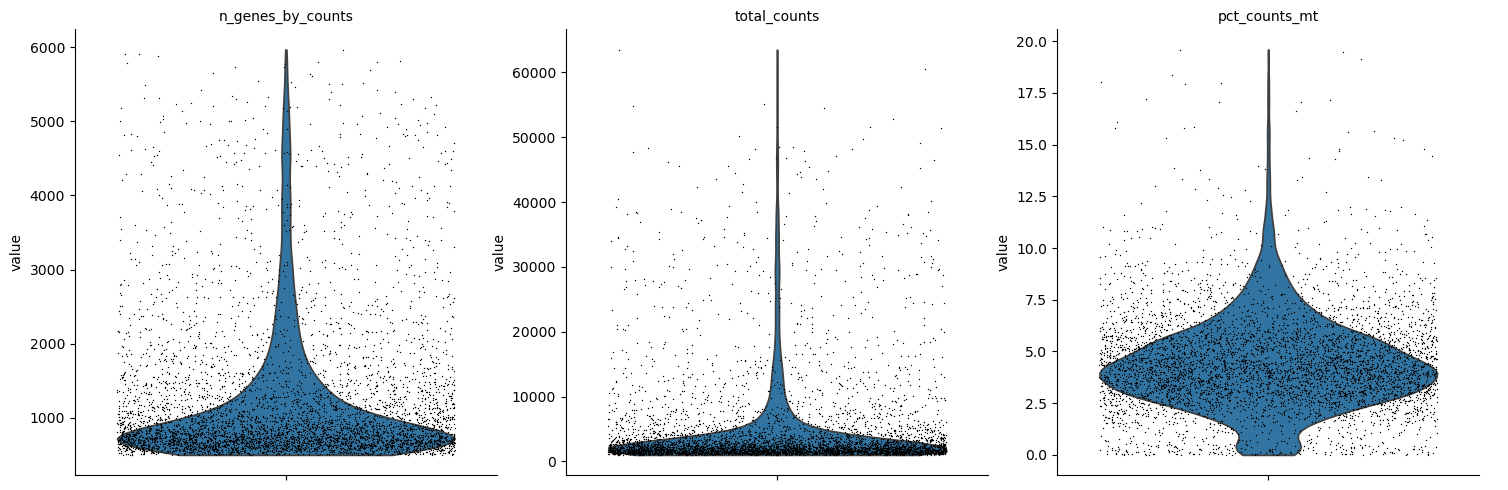

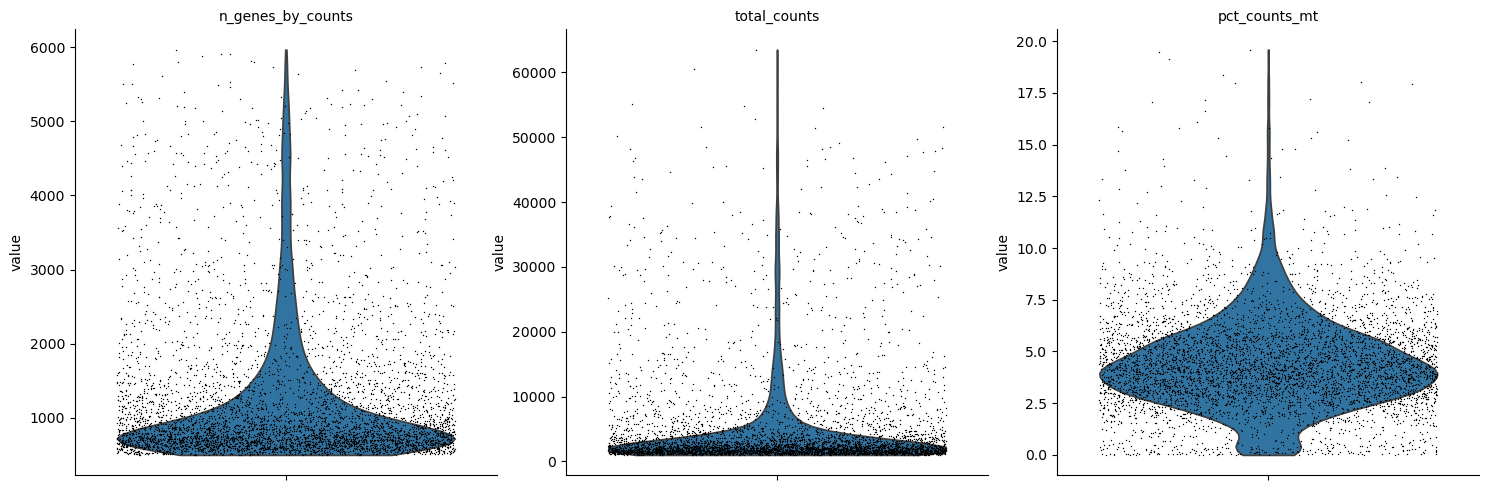

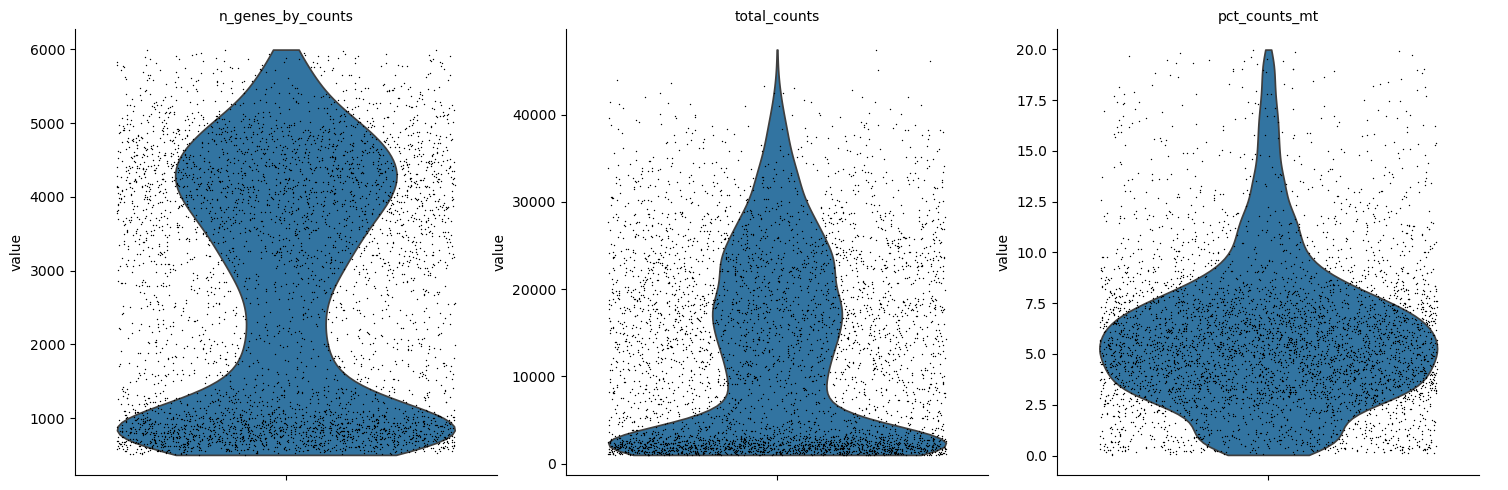

In [11]:
#  checking mitochondrial content, should not exceed 20%
sn_adata.var["mt"] = sn_adata.var_names.str.startswith(
    "MT-"
)  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(
    sn_adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
)
sc.pl.violin(
    sn_adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

# remove genes with high mitochondrial content
sc_adata.var["mt"] = sc_adata.var_names.str.startswith(
    "MT-"
)  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(
    sc_adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
)
sc.pl.violin(
    sc_adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

# remove genes with high mitochondrial content
sc_adata_test.var["mt"] = sc_adata_test.var_names.str.startswith(
    "MT-"
)  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(
    sc_adata_test, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
)
sc.pl.violin(
    sc_adata_test,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

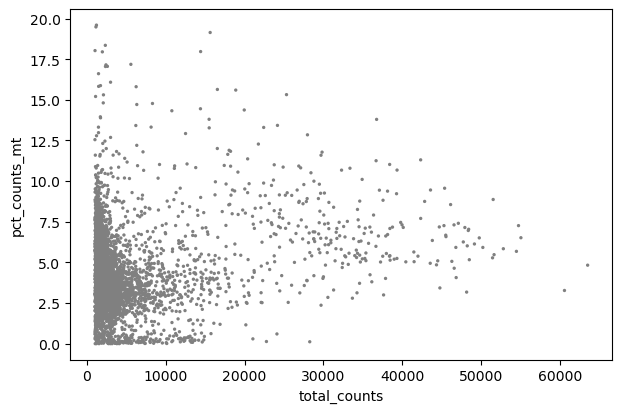

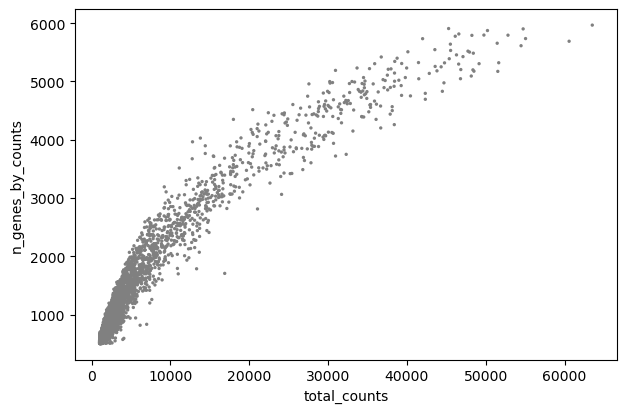

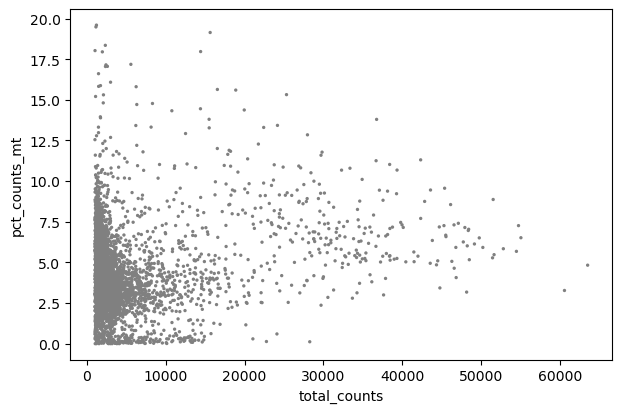

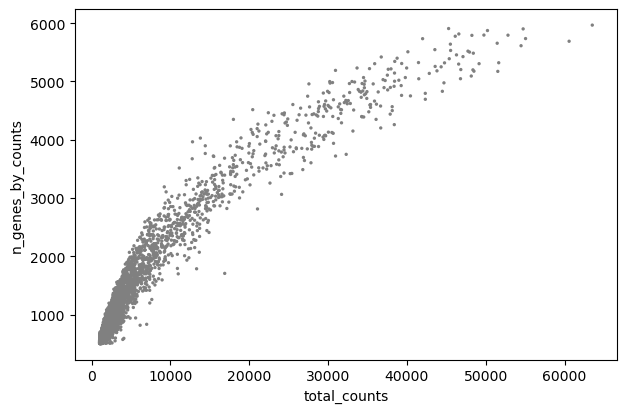

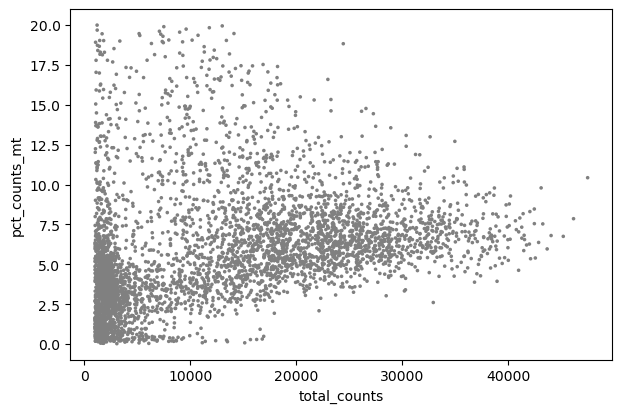

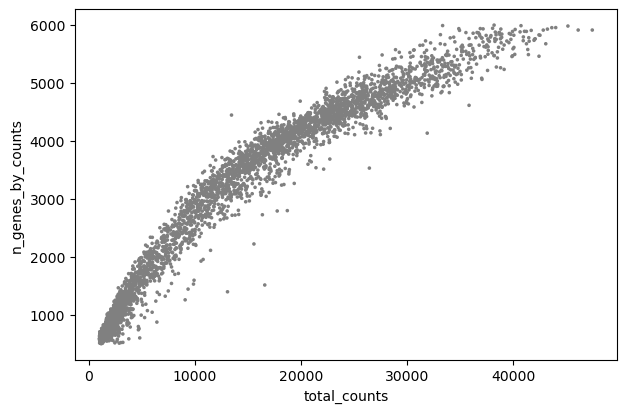

In [12]:
sc.pl.scatter(sn_adata, x="total_counts", y="pct_counts_mt")
sc.pl.scatter(sn_adata, x="total_counts", y="n_genes_by_counts")

sc.pl.scatter(sc_adata, x="total_counts", y="pct_counts_mt")
sc.pl.scatter(sc_adata, x="total_counts", y="n_genes_by_counts")

sc.pl.scatter(sc_adata_test, x="total_counts", y="pct_counts_mt")
sc.pl.scatter(sc_adata_test, x="total_counts", y="n_genes_by_counts")

## **Assigning cell types:**

In [13]:
sn_adata = assign_cell_types(sn_adata, sn_metadata["annotate"].values)
sc_adata = assign_cell_types(sc_adata, sc_metadata["annotate"].values)
sc_adata_test = assign_cell_types(sc_adata_test, sc_metadata_test["annotate"].values)

Done!
Cell Types in Data are: cell_types
T cell              2571
Macrophage           778
NK cell              725
Epithelial cell      605
Endothelial cell     231
B cell               124
Hepatocyte            72
Fibroblast            57
Name: count, dtype: int64
Done!
Cell Types in Data are: cell_types
T cell              2571
Macrophage           778
NK cell              725
Epithelial cell      605
Endothelial cell     231
B cell               124
Hepatocyte            72
Fibroblast            57
Name: count, dtype: int64
Done!
Cell Types in Data are: cell_types
Epithelial cell     3143
T cell               562
NK cell              233
Macrophage           223
Endothelial cell     163
Hepatocyte            50
Fibroblast            47
B cell                42
Name: count, dtype: int64


In [14]:
# making copy to keep unnormalized for export
sn_adata_copy = sn_adata.copy()
sc_adata_copy = sc_adata.copy()
sc_adata_test_copy = sc_adata_test.copy()

# normalize to 10K counts per cell
sc.pp.normalize_total(sn_adata, target_sum=1e4)
# logging local adata
sc.pp.log1p(sn_adata)

sc.pp.normalize_total(sc_adata, target_sum=1e4)
# logging local adata
sc.pp.log1p(sc_adata)

sc.pp.normalize_total(sc_adata_test, target_sum=1e4)
# logging local adata
sc.pp.log1p(sc_adata_test)

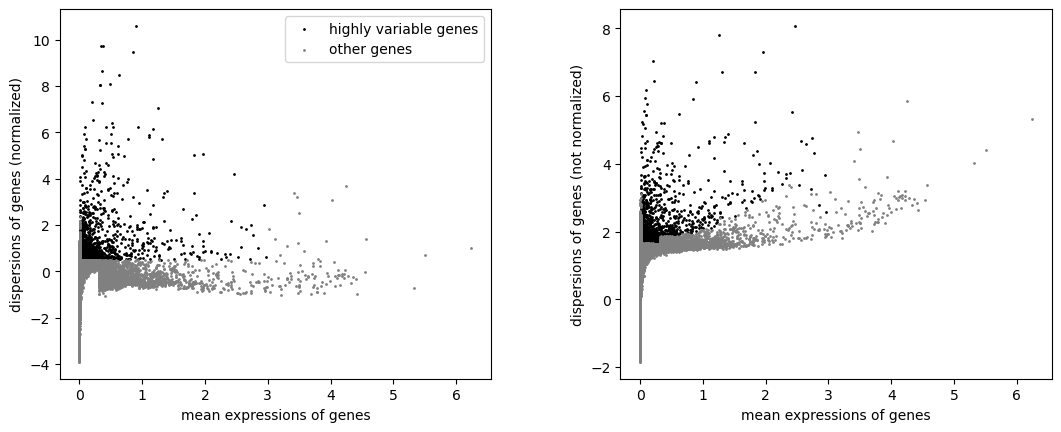

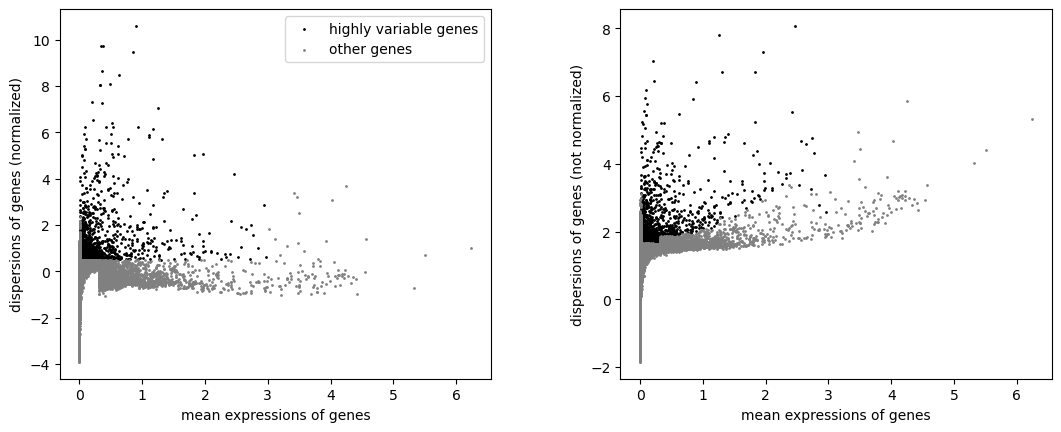

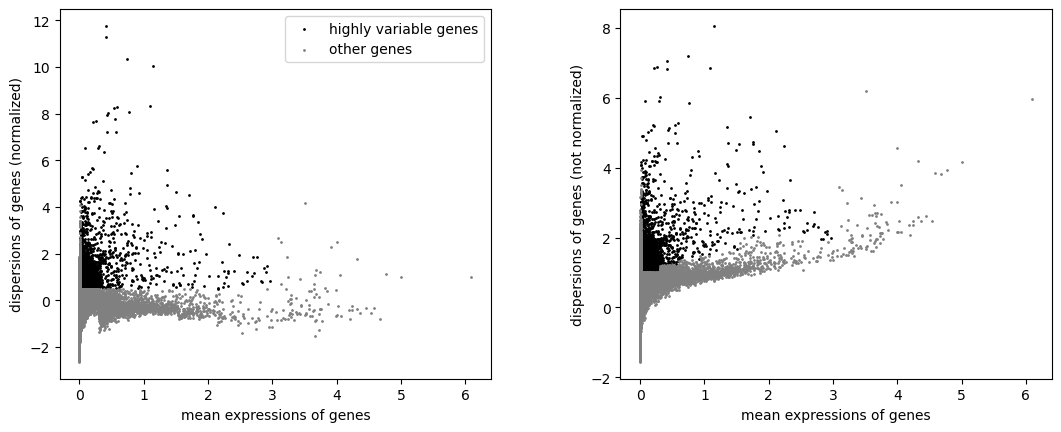

In [15]:
highly_var_genes = sc.pp.highly_variable_genes(
    sn_adata, min_mean=0.0125, max_mean=3, min_disp=0.5
)
sc.pl.highly_variable_genes(sn_adata)

highly_var_genes = sc.pp.highly_variable_genes(
    sc_adata, min_mean=0.0125, max_mean=3, min_disp=0.5
)
sc.pl.highly_variable_genes(sc_adata)

highly_var_genes = sc.pp.highly_variable_genes(
    sc_adata_test, min_mean=0.0125, max_mean=3, min_disp=0.5
)
sc.pl.highly_variable_genes(sc_adata_test)

/projects/aivich@xsede.org/.conda/envs/env_deconv/lib/python3.10/site-packages/scanpy/tools/_utils.py:41: UserWarning: You’re trying to run this on 32738 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  warnings.warn(


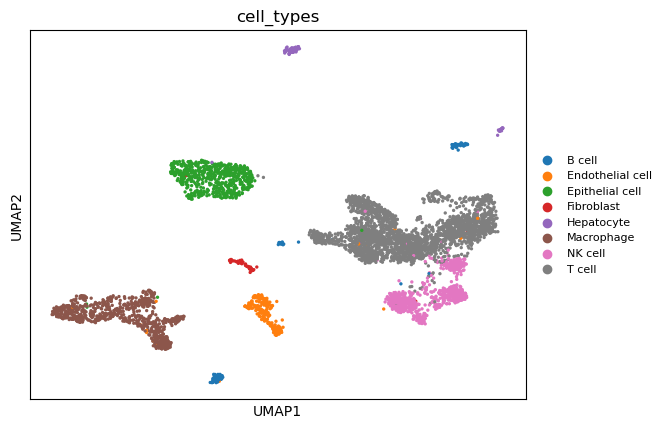

In [16]:
# calculate neighborhood graph
sc.pp.neighbors(sn_adata)

# make umap
sc.tl.umap(sn_adata)

# plot some markers of the RAW data
sc.pl.umap(sn_adata, color="cell_types", legend_fontsize=8)

/projects/aivich@xsede.org/.conda/envs/env_deconv/lib/python3.10/site-packages/scanpy/tools/_utils.py:41: UserWarning: You’re trying to run this on 32738 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  warnings.warn(


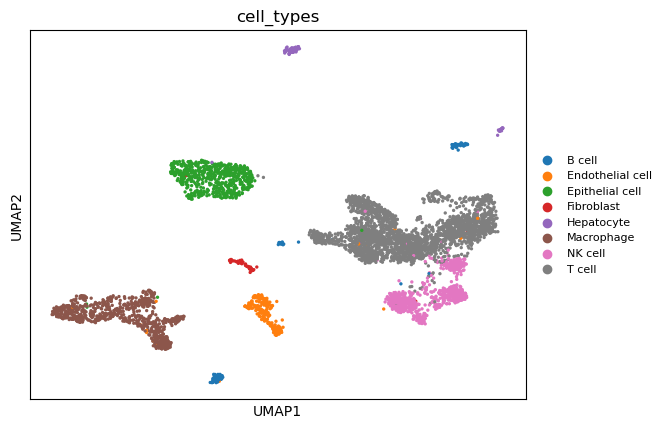

In [17]:
# calculate neighborhood graph
sc.pp.neighbors(sc_adata)

# make umap
sc.tl.umap(sc_adata)

# plot some markers of the RAW data
sc.pl.umap(sc_adata, color="cell_types", legend_fontsize=8)

/projects/aivich@xsede.org/.conda/envs/env_deconv/lib/python3.10/site-packages/scanpy/tools/_utils.py:41: UserWarning: You’re trying to run this on 33694 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  warnings.warn(


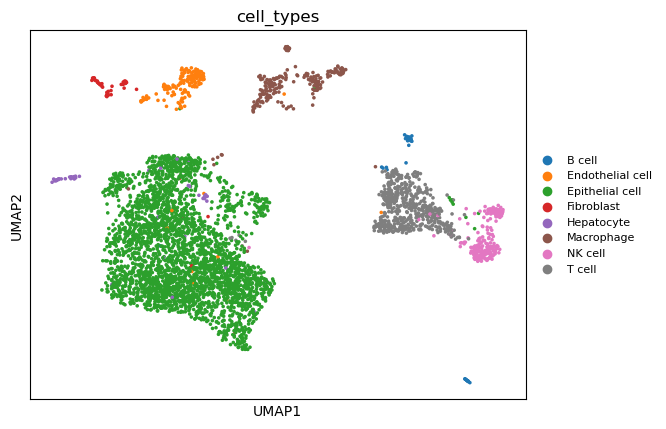

In [18]:
# calculate neighborhood graph
sc.pp.neighbors(sc_adata_test)

# make umap
sc.tl.umap(sc_adata_test)

# plot some markers of the RAW data
sc.pl.umap(sc_adata_test, color="cell_types", legend_fontsize=8)

## Cell type assignment QC:

In [19]:
# and repeat for unnormalized data
sn_adata_copy.obs["cell_types"] = sn_adata.obs["cell_types"]
sc_adata_copy.obs["cell_types"] = sc_adata.obs["cell_types"]
sc_adata_test_copy.obs["cell_types"] = sc_adata_test.obs["cell_types"]

In [20]:
sn_prop = make_prop_table(sn_adata, "cell_types")
sn_prop = sn_prop[:-1]
sn_prop.sort_values("Cell_Types")

,Cell_Types,Num_Cells,Prop_Cells
6,B cell,124,0.024017
3,Endothelial cell,231,0.044741
2,Epithelial cell,605,0.117180
7,Fibroblast,57,0.011040
4,Hepatocyte,72,0.013945
5,Macrophage,778,0.150688
1,NK cell,725,0.140422
0,T cell,2571,0.497966


In [21]:
sc_prop = make_prop_table(sc_adata, "cell_types")
sc_prop = sc_prop[:-1]
sc_prop.sort_values("Cell_Types")

,Cell_Types,Num_Cells,Prop_Cells
6,B cell,124,0.024017
3,Endothelial cell,231,0.044741
2,Epithelial cell,605,0.117180
7,Fibroblast,57,0.011040
4,Hepatocyte,72,0.013945
5,Macrophage,778,0.150688
1,NK cell,725,0.140422
0,T cell,2571,0.497966


In [22]:
sc_prop_test = make_prop_table(sc_adata_test, "cell_types")
sc_prop_test = sc_prop_test[:-1]
sc_prop_test.sort_values("Cell_Types")

,Cell_Types,Num_Cells,Prop_Cells
7,B cell,42,0.009411
3,Endothelial cell,163,0.036523
0,Epithelial cell,3143,0.704235
6,Fibroblast,47,0.010531
5,Hepatocyte,50,0.011203
4,Macrophage,223,0.049966
2,NK cell,233,0.052207
1,T cell,562,0.125924


## Now matching cell types in both

In [23]:
sn_adata, sc_adata = match_cell_types(
    sn_adata_copy,
    sc_adata_copy,
    np.intersect1d(sn_adata.obs.cell_types.unique(), sc_adata.obs.cell_types.unique()),
)

In [24]:
sc_adata_test, sc_adata = match_cell_types(
    sc_adata_test_copy,
    sc_adata_copy,
    np.intersect1d(
        sc_adata_test.obs.cell_types.unique(), sc_adata.obs.cell_types.unique()
    ),
)

In [25]:
# QC:
print("Cells in single-nucleus:")
print(sn_adata.obs.cell_types.unique())
print("Cells in single-cell:")
print(sc_adata.obs.cell_types.unique())
print("Cells in single-cell testing set:")
print(sc_adata_test.obs.cell_types.unique())

Cells in single-nucleus:
['T cell', 'NK cell', 'Epithelial cell', 'Endothelial cell', 'Hepatocyte', 'Macrophage', 'B cell', 'Fibroblast']
Categories (8, object): ['B cell', 'Endothelial cell', 'Epithelial cell', 'Fibroblast', 'Hepatocyte', 'Macrophage', 'NK cell', 'T cell']
Cells in single-cell:
['T cell', 'NK cell', 'Epithelial cell', 'Endothelial cell', 'Hepatocyte', 'Macrophage', 'B cell', 'Fibroblast']
Categories (8, object): ['B cell', 'Endothelial cell', 'Epithelial cell', 'Fibroblast', 'Hepatocyte', 'Macrophage', 'NK cell', 'T cell']
Cells in single-cell testing set:
['Epithelial cell', 'T cell', 'NK cell', 'Endothelial cell', 'Macrophage', 'Hepatocyte', 'Fibroblast', 'B cell']
Categories (8, object): ['B cell', 'Endothelial cell', 'Epithelial cell', 'Fibroblast', 'Hepatocyte', 'Macrophage', 'NK cell', 'T cell']


## Saving both

In [26]:
# These should not be normalized
print(sn_adata.X.max())
print(sc_adata.X.max())
print(sc_adata_test.X.max())

8788.0
8788.0
8351.0


## Finally matching genes

In [27]:
genes_to_keep = sorted(set(sn_adata.var_names.values)&set(sc_adata.var_names.values)&set(sc_adata_test.var_names.values))
genes_to_keep

['A1BG',
 'A1BG-AS1',
 'A1CF',
 'A2M',
 'A2M-AS1',
 'A2ML1',
 'A2ML1-AS1',
 'A2ML1-AS2',
 'A3GALT2',
 'A4GALT',
 'A4GNT',
 'AAAS',
 'AACS',
 'AADAC',
 'AADACL2',
 'AADACL3',
 'AADACL4',
 'AADAT',
 'AAED1',
 'AAGAB',
 'AAK1',
 'AAMDC',
 'AAMP',
 'AANAT',
 'AAR2',
 'AARD',
 'AARS',
 'AARS2',
 'AARSD1',
 'AASDH',
 'AASDHPPT',
 'AASS',
 'AATF',
 'AATK',
 'AATK-AS1',
 'AB019440.50',
 'ABAT',
 'ABCA1',
 'ABCA10',
 'ABCA12',
 'ABCA13',
 'ABCA2',
 'ABCA3',
 'ABCA4',
 'ABCA5',
 'ABCA6',
 'ABCA7',
 'ABCA8',
 'ABCA9',
 'ABCA9-AS1',
 'ABCB1',
 'ABCB10',
 'ABCB11',
 'ABCB4',
 'ABCB5',
 'ABCB6',
 'ABCB7',
 'ABCB8',
 'ABCB9',
 'ABCC1',
 'ABCC10',
 'ABCC11',
 'ABCC12',
 'ABCC2',
 'ABCC3',
 'ABCC4',
 'ABCC5',
 'ABCC5-AS1',
 'ABCC6',
 'ABCC8',
 'ABCC9',
 'ABCD1',
 'ABCD2',
 'ABCD3',
 'ABCD4',
 'ABCE1',
 'ABCF1',
 'ABCF2',
 'ABCF3',
 'ABCG1',
 'ABCG2',
 'ABCG4',
 'ABCG5',
 'ABCG8',
 'ABHD1',
 'ABHD10',
 'ABHD11',
 'ABHD12',
 'ABHD12B',
 'ABHD13',
 'ABHD14A',
 'ABHD14A-ACY1',
 'ABHD14B',
 'ABHD15',
 'ABHD

In [28]:
sn_adata = sn_adata[:, genes_to_keep]
sc_adata = sc_adata[:, genes_to_keep]
sc_adata_test = sc_adata_test[:, genes_to_keep]

In [29]:
sc_adata_test.obs["deconvolution"] = "pseudobulks"
sc_adata.obs["deconvolution"] = "reference"
sn_adata.obs["deconvolution"] = "reference"

/projects/aivich@xsede.org/code-server/tmp/ipykernel_3535916/770530534.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  sc_adata_test.obs["deconvolution"] = "pseudobulks"
/projects/aivich@xsede.org/code-server/tmp/ipykernel_3535916/770530534.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  sc_adata.obs["deconvolution"] = "reference"
/projects/aivich@xsede.org/code-server/tmp/ipykernel_3535916/770530534.py:3: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  sn_adata.obs["deconvolution"] = "reference"


QC:

In [30]:
print(sn_adata)
print(sc_adata)
print(sc_adata_test)

AnnData object with n_obs × n_vars = 5163 × 30316
    obs: 'data_type', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'cell_types', 'deconvolution'
    var: 'gene_ids', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
AnnData object with n_obs × n_vars = 5163 × 30316
    obs: 'data_type', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'cell_types', 'deconvolution'
    var: 'gene_ids', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
AnnData object with n_obs × n_vars = 4463 × 30316
    obs: 'data_type', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'cell_types', 'deconvolution'
    var: 'gene_ids', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'


In [31]:
maps = {
    "dendritic cell": "Dendritic Cells",
    "endothelial cell": "Endothelial Cells",
    "immature NK T cell": "Immature NK T Cells",
    "monocyte": "Monocytes",
    "preadipocyte": "Preadipocytes",
    "T cell": "T Cells",
    "Endothelial cell": "Endothelial Cells",
    "T cell": "T Cells",
    "Macrophage": "Macrophages",
    "macrophage": "Macrophages",
    "Hepatocyte": "Hepatocytes",
    "Epithelial cell": "Epithelial Cells",
}
sn_adata.obs.cell_types = sn_adata.obs.cell_types.replace(maps)
sc_adata.obs.cell_types = sc_adata.obs.cell_types.replace(maps)
sc_adata_test.obs.cell_types = sc_adata_test.obs.cell_types.replace(maps)

In [32]:
print(sn_adata.obs.cell_types.value_counts())
print(sc_adata.obs.cell_types.value_counts())
print(sc_adata_test.obs.cell_types.value_counts())

cell_types
T Cells              2571
Macrophages           778
NK cell               725
Epithelial Cells      605
Endothelial Cells     231
B cell                124
Hepatocytes            72
Fibroblast             57
Name: count, dtype: int64
cell_types
T Cells              2571
Macrophages           778
NK cell               725
Epithelial Cells      605
Endothelial Cells     231
B cell                124
Hepatocytes            72
Fibroblast             57
Name: count, dtype: int64
cell_types
Epithelial Cells     3143
T Cells               562
NK cell               233
Macrophages           223
Endothelial Cells     163
Hepatocytes            50
Fibroblast             47
B cell                 42
Name: count, dtype: int64


In [33]:
all_adatas = sc.concat([sn_adata, sc_adata_test, sc_adata])

/projects/aivich@xsede.org/.conda/envs/env_deconv/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [34]:
path = f"{os.getcwd()}/../data/{res_name}/"
# saving for later adata as anndata without normalization
adata_path = os.path.join(path, f"sc_sn_{res_name}_processed.h5ad")
adata_path = Path(adata_path)
all_adatas.write_h5ad(adata_path)